# 1.3 Performing AM in Code Space

## Introduction

**This section corresponds to Section 3.3 in the original paper.**

Learning density models $p(x)$ that directly approximate the data distribution can be difficult, or even nearly impossible for complex datasets. Generative models do not explicitly provide the density function but are able to sample from it through the following steps:

1. Sample from a simple distribution $q(z) \sim \mathcal{N}(0,I)$ defined in some abstract code space $\mathcal{Z}$.
2. Apply to the sample a decoding function $g : \mathcal{Z} \rightarrow \mathcal{X}$ that maps it back to the original input domain.

One such model that have gained popularity over the recent years is the Generative Adversarial Network (GAN). It learns a decoding function $g$ such that the generated images are theoretically impossible to distinguish from real images. The decoding function (generator) and the discriminant (discriminator) are typically neural networks. Here are some [great](https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/) [blogs](http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/) on GANs, if you are not familiar with them.

[Nguyen et al.](https://arxiv.org/abs/1605.09304) proposed a method of building prototype images $x^{*}$ for each labels $\omega_c$ by incorporating a pretrained generative model into the activation maximization framework. The optimization objective is redefined as (check tutorial 1.1 if you don't remember the original objective):

$$\max_{z \, \in \, \mathcal{Z}} \log p(\omega_c \, | \, g(z)) - \lambda \lVert z\rVert^2$$

Now, instead of optimizing an image, we are optimizing the code $z$ such that the generated image $g(z)$ will maximize the activation for a particular class $\omega_c$. Once the solution $z^{*}$ to the optimization problem is found, the prototype for $\omega_c$ is generated by passing $z^{*}$ through the generator. That is, $x^{*} = g(z^{*})$. Hopefully, the prototype will turn out to be more realistic than vanilla AM, as the generator knows how to generate natural-looking images.

## Training Details

Remember how I said we incorporate a *pretrained* generative model into the AM framework? Here I will explain how we train the generator. The paper for this particular GAN framework by Nguyen et al. can be found [here](https://arxiv.org/abs/1602.02644). First take a look at the overall schematic for the GAN framework.

![title](./assets/1_3_AM_Code/schematic.png)

The training process involves four networks:

1. A pretrained encoder network $E$ to be inverted.
2. A generator network $G$.
3. A pretrained classifier $C$.
4. A discriminator $D$.

Note that we only have three networks in the above schematic while we require four. This is because the pretrained classifier serves as both $E$ and $C$. The activation of the hidden layer of the pretrained network acts as an encoding of the input as well as a means of comparing prominent features of two images. Now that we have figured out the components of this framework, let's see how the loss functions for $G$ and $D$ are defined. There are three parts.

#### Loss in Feature Space

Given a classifier $C: \mathbb{R}^{W \times H \times C} \rightarrow \mathbb{R}^{F}$, we define

$$L_{feat} = \sum_i \lVert C(G(x_i)) - C(y_i) \rVert^2$$

where $y_i$ is the real image and $x_i$ is the encoding of $y_i$. With this loss, we are trying to encourage the generator to produce images whose features are similar to those of real images.

#### Adversarial Loss

The discriminator loss $L_{discr}$ and the generator loss $L_{adv}$ is given as follows:

$$L_{discr} = - \sum_i \log (D(y_i)) + \log (1 - D(G(x_i)))$$
$$L_{adv} = - \sum_i \log (D(G(x_i))$$

This is just the GAN objective that constrains the generator to produce natural-looking images.

#### Loss in Image Space

Adding a pixel-wise loss stabilizes training.

$$L_{img} = \sum_i \lVert G(x_i) -  y_i \rVert^2$$

Now that we have a pretrained generator, we can simply plug $G$ into the AM framework. As I mentioned above, we are **not** training the generator nor the classifier. We are optimizing the code $z$ that goes into the generator such that the generated image maximizes the activation for the class $\omega_c$.

![title](./assets/1_3_AM_Code/schematic2.png)

## Tensorflow Walkthrough

### 1. Import Dependencies

We import the classifier (DNN), generator and the discriminator-the three components necessary for this AM framework.

In [2]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_1_3 import MNIST_DNN, MNIST_G, MNIST_D
from utils import plot

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/1_3_AM_Code/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building DNN Graph

In this step, we initialize a DNN classifier and attach necessary nodes for model training onto the computation graph.

In [3]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_DNN('DNN')

    # Setup training process
    lmda = tf.placeholder_with_default(0.01, shape=[], name='lambda')
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    tf.add_to_collection('placeholders', lmda)
    tf.add_to_collection('placeholders', X)
    tf.add_to_collection('placeholders', Y)

    code, logits = DNN(X)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Building GAN Subgraph

We now build the GAN part of the computation graph. If you see the right hand side of the $G$ cost, you can see that it is comprised of three terms. They are $L_{adv}$, $L_{img}$ and $L_{feat}$ from left to right.

In [4]:
with tf.name_scope('GAN'):

    G = MNIST_G(z_dim=100, name='Generator')
    D = MNIST_D(name='Discriminator')

    X_fake = G(code)
    D_real = D(X)
    D_fake = D(X_fake, reuse=True)
    code_fake, logits_fake = DNN(X_fake, reuse=True)

    D_cost = -tf.reduce_mean(tf.log(D_real + 1e-7) + tf.log(1 - D_fake + 1e-7))
    G_cost = -tf.reduce_mean(tf.log(D_fake + 1e-7)) + tf.nn.l2_loss(X_fake - X) + tf.nn.l2_loss(code_fake - code)

    D_optimizer = tf.train.AdamOptimizer().minimize(D_cost, var_list=D.vars)
    G_optimizer = tf.train.AdamOptimizer().minimize(G_cost, var_list=G.vars)

### 4. Building Subgraph for Generating Prototypes

Before training the network, a subgraph for generating prototypes is added onto the graph. This subgraph will be used after training the model.

In [5]:
with tf.name_scope('Prototype'):
    
    code_mean = tf.placeholder(tf.float32, [10, 100], name='code_mean')
    code_prototype = tf.get_variable('code_prototype', shape=[10, 100], initializer=tf.random_normal_initializer())

    X_prototype = G(code_prototype, reuse=True)
    Y_prototype = tf.one_hot(tf.cast(tf.lin_space(0., 9., 10), tf.int32), depth=10)
    _, logits_prototype = DNN(X_prototype, reuse=True)

    # Objective function definition
    cost_prototype = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_prototype, labels=Y_prototype)) \
                     + lmda * tf.nn.l2_loss(code_prototype - code_mean)

    optimizer_prototype = tf.train.AdamOptimizer().minimize(cost_prototype, var_list=[code_prototype])

# Add the subgraph nodes to a collection so that they can be used after training of the network
tf.add_to_collection('prototype', code)
tf.add_to_collection('prototype', code_mean)
tf.add_to_collection('prototype', code_prototype)
tf.add_to_collection('prototype', X_prototype)
tf.add_to_collection('prototype', Y_prototype)
tf.add_to_collection('prototype', logits_prototype)
tf.add_to_collection('prototype', cost_prototype)
tf.add_to_collection('prototype', optimizer_prototype)

This is the general structure of the computation graph visualized using tensorboard.

![title](./assets/1_3_AM_Code/graph.png)

### 5. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)
    
    print('Epoch: {:04d} cost = {:.9f} accuracy = {:.9f}'.format(epoch + 1, avg_cost, avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

Epoch: 0001 cost = 0.237656591 accuracy = 0.930690911
Epoch: 0002 cost = 0.088291109 accuracy = 0.972981828
Epoch: 0003 cost = 0.055177446 accuracy = 0.982690919
Epoch: 0004 cost = 0.037826146 accuracy = 0.988145463
Epoch: 0005 cost = 0.029179757 accuracy = 0.990963644
Epoch: 0006 cost = 0.023033684 accuracy = 0.992272734
Epoch: 0007 cost = 0.017406837 accuracy = 0.994400005
Epoch: 0008 cost = 0.015977912 accuracy = 0.994672732
Epoch: 0009 cost = 0.013727595 accuracy = 0.995818186
Epoch: 0010 cost = 0.011904787 accuracy = 0.996363640
Epoch: 0011 cost = 0.015322508 accuracy = 0.994763641
Epoch: 0012 cost = 0.010558971 accuracy = 0.996327276
Epoch: 0013 cost = 0.009135132 accuracy = 0.997018185
Epoch: 0014 cost = 0.008601392 accuracy = 0.997127275
Epoch: 0015 cost = 0.008166363 accuracy = 0.997127275
Accuracy: 0.98


### 6. Training GAN

We now train $G$ (and $D$) according to the description above.

In [7]:
# Hyper parameters
training_epochs = 25
batch_size = 100
img_epoch = 1

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_D_cost = 0
    avg_G_cost = 0
    
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs}

        _, D_c = sess.run([D_optimizer, D_cost], feed_dict=feed_dict)
        _, G_c = sess.run([G_optimizer, G_cost], feed_dict=feed_dict)

        avg_D_cost += D_c / total_batch
        avg_G_cost += G_c / total_batch
        
    print('Epoch: {:04d} G cost = {:.9f} D cost = {:.9f}'.format(epoch + 1, avg_G_cost, avg_D_cost))

# Uncomment this code if you want to see the generated images.
#
#     if (epoch + 1) % img_epoch == 0:
#         samples = sess.run(X_fake, feed_dict={X: mnist.test.images[:16, :]})
#         fig = plot(samples, 784, 1)
#         plt.savefig('./assets/1_3_AM_Code/G_{:04d}.png'.format(epoch), bbox_inches='tight')
#         plt.close(fig)
    
    saver.save(sess, ckptdir)

sess.close()

Epoch: 0001 G cost = 5281.714079368 D cost = 0.017211454
Epoch: 0002 G cost = 2569.694126864 D cost = 0.006985294
Epoch: 0003 G cost = 2222.643753551 D cost = 0.007533360
Epoch: 0004 G cost = 2040.322469150 D cost = 0.007319166
Epoch: 0005 G cost = 1915.783002042 D cost = 0.007434430
Epoch: 0006 G cost = 1825.571832386 D cost = 0.004931086
Epoch: 0007 G cost = 1751.774513494 D cost = 0.005131674
Epoch: 0008 G cost = 1695.891795987 D cost = 0.005583258
Epoch: 0009 G cost = 1648.915287420 D cost = 0.004081625
Epoch: 0010 G cost = 1606.690468084 D cost = 0.004811222
Epoch: 0011 G cost = 1574.847379927 D cost = 0.002461862
Epoch: 0012 G cost = 1548.405506925 D cost = 0.004549469
Epoch: 0013 G cost = 1523.959982688 D cost = 0.004773995
Epoch: 0014 G cost = 1502.840756392 D cost = 0.001094513
Epoch: 0015 G cost = 1484.560579057 D cost = 0.003348438
Epoch: 0016 G cost = 1470.541124157 D cost = 0.001267561
Epoch: 0017 G cost = 1452.866942472 D cost = 0.006172946
Epoch: 0018 G cost = 1441.05568

This is a visualization of the GAN training process. The image quality initially improves although it somewhat plateaus out in the later epochs.

![title](./assets/1_3_AM_Code/train.gif)

### 7. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the `tf.get_collection()` function (recall prototype subgraph nodes were added onto the 'prototype' collection at step 4).

In [8]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

# Get necessary placeholders
placeholders = tf.get_collection('placeholders')
lmda = placeholders[0]
X = placeholders[1]

# Get prototype nodes
prototype = tf.get_collection('prototype')
code = prototype[0]
code_mean = prototype[1]
X_prototype = prototype[3]
cost_prototype = prototype[6]
optimizer_prototype = prototype[7]

INFO:tensorflow:Restoring parameters from ./tf_logs/1_3_AM_Code/model


### 8. Generating Prototype Images

Before performing gradient ascent, we calculate the image means $\overline{z}$ that will be used to regularize the prototype images. Then, we generate prototype images that maximize $\log p(\omega_c \, | \, g(z)) - \lambda \lVert z - \overline{z}\rVert^2$. I used 0.1 for lambda (lmda), but fine tuning may produce better prototype images.

In [9]:
images = mnist.train.images
labels = mnist.train.labels

code_means = []
for i in range(10):
    imgs = images[np.argmax(labels, axis=1) == i]
    img_codes = sess.run(code, feed_dict={X: imgs})
    code_means.append(np.mean(img_codes, axis=0))

for epoch in range(15000):
    _, c = sess.run([optimizer_prototype, cost_prototype], feed_dict={lmda: 0.1, code_mean: code_means})
    
    if epoch % 500 == 0:
        print('Epoch: {:05d} Cost = {:.9f}'.format(epoch, c))
    
X_prototypes = sess.run(X_prototype)

sess.close()

Epoch: 00000 Cost = 358.779754639
Epoch: 00500 Cost = 275.063323975
Epoch: 01000 Cost = 214.894088745
Epoch: 01500 Cost = 168.886154175
Epoch: 02000 Cost = 132.707305908
Epoch: 02500 Cost = 103.784980774
Epoch: 03000 Cost = 80.557037354
Epoch: 03500 Cost = 61.938266754
Epoch: 04000 Cost = 47.098171234
Epoch: 04500 Cost = 35.386249542
Epoch: 05000 Cost = 26.258031845
Epoch: 05500 Cost = 19.242551804
Epoch: 06000 Cost = 13.927100182
Epoch: 06500 Cost = 9.950549126
Epoch: 07000 Cost = 7.006939888
Epoch: 07500 Cost = 4.849003792
Epoch: 08000 Cost = 3.284199476
Epoch: 08500 Cost = 2.165551901
Epoch: 09000 Cost = 1.380895495
Epoch: 09500 Cost = 0.844008684
Epoch: 10000 Cost = 0.488746434
Epoch: 10500 Cost = 0.264367282
Epoch: 11000 Cost = 0.131287798
Epoch: 11500 Cost = 0.058500197
Epoch: 12000 Cost = 0.022639306
Epoch: 12500 Cost = 0.007277159
Epoch: 13000 Cost = 0.001836700
Epoch: 13500 Cost = 0.000343904
Epoch: 14000 Cost = 0.000050971
Epoch: 14500 Cost = 0.000013767


### 9. Displaying Images

By incorporating $G$ into the AM framework, we are now able to produce realistic images. Recall that just using AM resulted in blurry prototype images.

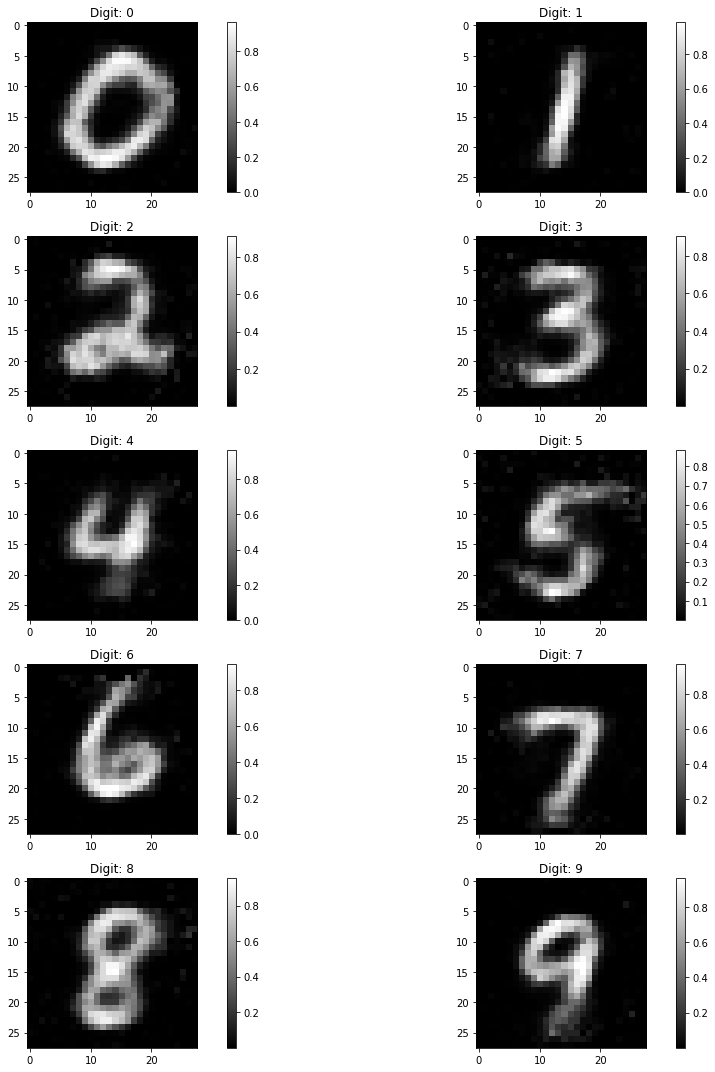

In [10]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(X_prototypes[2 * i], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(X_prototypes[2 * i + 1], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()